# Car pricing

**Input data:** Frank Verboven's car dataset: https://sites.google.com/site/frankverbo/data-and-software/data-set-on-the-european-car-market

In [1]:
import pandas as pd 
import numpy as np 
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt

# various helper-files 
import cardata

This switch controls whether to use the nested logit model or the simple conditional logit. More on this later. 

In [2]:
NESTEDLOGIT = True

# Read in data

In [3]:
cars = pd.read_excel('cars.xlsx')

# pick regressors (NOTE: price variable must be first)
xvars = ['eurpr', 'we', 'hp', 'li']
zvars = [f'log_{x}' for x in xvars] # log versions 
cardata.process_data(cars, xvars)

A quick peak at the market shares of different brands across countries. 

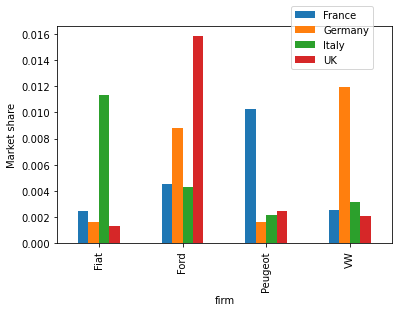

In [4]:
I = (cars.firm.isin(['VW', 'Fiat', 'Ford', 'Peugeot'])) & (cars.market.isin(['Germany', 'Italy', 'UK', 'France'])) 
ax = cars.loc[I].groupby(['firm', 'market']).market_share.mean().dropna().unstack().plot(kind='bar'); 
ax.legend(loc=(.7,.8)); 
ax.set_ylabel('Market share'); 

# Estimate model parameters

In [5]:
betahat, xi, rho = cardata.estimate(cars, yvar='d_l_market_share', zvars=zvars, NESTEDLOGIT=NESTEDLOGIT)

--- Parameter estimates (omitting fixed effects) ---
log_eurpr                   -0.872476
log_we                       2.394577
log_hp                      -0.694630
log_li                      -1.139342
d_l_market_share_of_class    0.563120
dtype: float64


In [6]:
countries = np.sort(cars['ma'].unique())
years     = np.sort(cars['ye'].unique())
carcodes  = np.sort(cars['co'].unique())

T = len(years)
N = len(countries)
J = len(carcodes)

# From pandas to numpy

Converting from a pandas dataframe (where the # of rows per country varies) to a balanced matrix format, where all data objects are `J*T*N`. 

**Results** in the matrices `s` (for market **s**hares), and `z` (for car characteristics), and `available`. 

In [7]:
cars = cars.set_index(['ma', 'ye', 'co']).sort_index()

In [8]:
# matrix of market shares 
s = cardata.dataframe2matrix(cars, 'market_share', J,T,N)
available = np.isnan(s) == False

# matrix of car characteristics
Nz = len(zvars)
z = np.nan * np.zeros((Nz, J, T, N))
for i,zvar in enumerate(zvars): 
    z[i, :,:,:] = cardata.dataframe2matrix(cars, zvar, J,T,N)

Print avg. values of car characteristics (always good to check they are not badly scaled)

In [9]:
zavg = np.nanmean(z.reshape(Nz, J*T*N), 1)
for i,zvar in enumerate(zvars): 
    print(f'{zvar: <10}: {zavg[i]: 8.4f}')

log_eurpr :   8.8239
log_we    :  -0.0481
log_hp    :   3.9580
log_li    :   2.0808


Useful to have a few neat variables in matrix form as well. In `cars`, they are in "unbalanced" form, so we transform them to the `J*T*N` matrices, which are in the logic of the logit model running in the background. 

In [10]:
firms    = cardata.dataframe2matrix(cars, 'firm', J, T, N)
carclass = cardata.dataframe2matrix(cars, 'cla' , J, T, N)
types    = cardata.dataframe2matrix(cars, 'type', J, T, N)

Set up nests for nested logit if that is required. 

In [11]:
if NESTEDLOGIT: 
    nest_id = np.zeros((J,T,N), dtype=np.int)  # initialize
    # overwrite for available and switch base 1 -> 0 
    nest_id[available] = carclass[available]-1 
else: 
    # then, choice_probs() will assume we are using regular logit
    nest_id = None
    rho = None

# Setting up for price competition 

This section takes care of the setup required before we can investigate price competition among two cars. 

## Choosing `i,t,j1,j2`

We first choose which two cars to focus on and in which market (`i`) and year (`t`)

In [12]:
i = 2
t = 29
population = cars.loc[countries[i]].loc[years[t]]['pop'].unique()[0]
print(f'--- Game takes place in {1970 + t} in {cardata.market_name[i]} (market size = {population:,.0f})---')

j_possible = [j for j in range(J) if available[j,t,i]]
j1 = 117
j2 = 193

--- Game takes place in 1999 in Germany (market size = 8,202,000)---


In [13]:
# check we have not made a stupid choice 
for j in [j1, j2]: 
    assert available[j,t,i], f'Car {j} not available! Pick another'

In [14]:
carname1 = types[j1,t,i]
class1 = cardata.class_name[(carclass[j1,t,i]-1).astype(int)]
print(f'Player 1 will be pricing {carname1:<20} (j = {j1:3d}), s = {s[j1,t,i]*100.:7.2f}%, class {class1}, {(s[j1,t,i]*population).astype(int):,d} cars sold')

carname2 = types[j2,t,i]
class2 = cardata.class_name[(carclass[j2,t,i]-1).astype(int)]
print(f'Player 2 will be pricing {carname2:<20} (j = {j2:3d}), s = {s[j2,t,i]*100.:7.2f}%, class {class2}, {(s[j2,t,i]*population).astype(int):,d} cars sold')

Player 1 will be pricing opel astra           (j = 117), s =    2.81%, class compact, 230,224 cars sold
Player 2 will be pricing volkswagen golf      (j = 193), s =    3.82%, class compact, 313,289 cars sold


## Marginal cost

In [15]:
i_p = 0 
p1_data = np.exp(z[i_p,j1,t,i])
p2_data = np.exp(z[i_p,j2,t,i])

print(f'In the data, the price is p1 = {p1_data: 10.2f} EUR for the {carname1}')
print(f'In the data, the price is p1 = {p2_data: 10.2f} EUR for the {carname2}')

marc_cost_frac = 0.5
print(f'Assuming that marginal cost are {marc_cost_frac:.0%} of baseline prices')
c1 = p1_data*marc_cost_frac
c2 = p2_data*marc_cost_frac

In the data, the price is p1 =   10014.68 EUR for the opel astra
In the data, the price is p1 =   10529.41 EUR for the volkswagen golf
Assuming that marginal cost are 50% of baseline prices


## Firm payoffs

Note: these are implicit functions of many other variables

This function just calls `cardata.choice_prob()` and computes choice probabilities for *all* cars and selects the cells corresponding to our choice of `i,t,j1,j2`. 

In [16]:
for i_p,v in enumerate(zvars): 
    if v == 'log_eurpr': 
        break
print(f'Price variable at index: {i_p}')

Price variable at index: 0


In [17]:
def compute_market_shares(p1,p2): 
    '''
        INPUTS: 
            p1,p2: scalar, prices for firm 1 and 2 respectively 
        OUTPUTS: 
            s1,s2: scalars, market shares for firm 1 and 2 respectively 
    '''
    
    # 1. construct counterfactual z-matrix
    z2 = np.copy(z)
    z2[0,j1,t,i] = np.log(p1)
    z2[0,j2,t,i] = np.log(p2)
    
    # 2. predict market shares 
    probs = cardata.choice_prob(xi, z2, betahat, available, rho, nest_id)
    
    # 3. return shares for selected cars 
    s1 = probs[j1,t,i]
    s2 = probs[j2,t,i]
    
    return s1, s2

def payoffs(p1,p2): 
    '''
        INPUTS: 
            p1,p2: scalar, prices for firm 1 and 2 respectively 
        OUTPUTS: 
            pi1,pi2: scalars, market shares for firm 1 and 2 respectively 
    '''
    s1,s2 = compute_market_shares(p1,p2)
    
    # profits in million EUR
    pi1 = (p1-c1) * s1 * population / 1000000 
    pi2 = (p2-c2) * s2 * population / 1000000 
    
    return pi1,pi2

# Price competition

Now that we have demand functions, we can investigate the elasticity of residual demand 

In [18]:
# compute elasticity of demand 
s1,s2   = compute_market_shares(p1_data, p2_data)
s1_,s2_ = compute_market_shares(p1_data*1.01, p2_data)

own_elast   = (s1_ - s1)/s1 * (1.0 / 0.01)
cross_elast = (s2_ - s2)/s2 * (1.0 / 0.01)
print(f'elasticity, own   = {own_elast: 5.2%}')
print(f'elasticity, cross = {s2_/s2-1.0: %}')

elasticity, own   = -191.57%
elasticity, cross =  0.052882%


In [19]:
s1,s2 = compute_market_shares(p1_data, p2_data)

In [20]:
pi1, pi2 = payoffs(p1_data, p2_data)

In [21]:
print('Baseline predicted profits:')
print(f'1: {pi1:8.2f} mio. EUR ({carname1})')
print(f'2: {pi2:8.2f} mio. EUR ({carname2})')

Baseline predicted profits:
1:    16.47 mio. EUR (opel astra)
2:    14.67 mio. EUR (volkswagen golf)


In [22]:
def payoff_i(p1, p2, i): 
        
    pi1, pi2 = payoffs(p1, p2)
    
    if i == 1: 
        return pi1
    else: 
        return pi2

At the outset, player 1 makes 16.47m EUR (predicted)


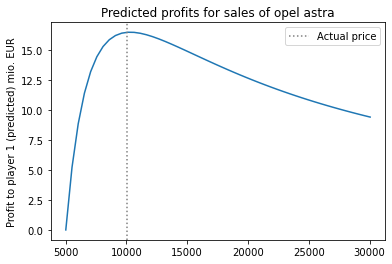

In [26]:
goal = lambda p : payoff_i(p, p2_data, 1)

print(f'At the outset, player 1 makes {goal(p1_data):5.2f}m EUR (predicted)')

pp = np.linspace(c1, p1_data*3.0, 50)
yy = np.empty(pp.shape)
for ip,p in enumerate(pp): 
    yy[ip] = goal(p)
    
plt.plot(pp, yy); 
plt.axvline(p1_data, linestyle=':', c='gray', label='Actual price')
plt.legend(loc='best'); 
plt.ylabel('Profit to player 1 (predicted) mio. EUR'); 
plt.title(f'Predicted profits for sales of {carname1}'); 